In [420]:
# Had issues installing pyreadstat so used magic command in notebook instead
# %pip install pyreadstat

import glob
import pyreadstat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from pathlib import Path

In [421]:
# Establish path to data folder
DATA_DIR = Path('/Volumes/WRKGRP/STD-FSW-BSI-SD-Movement_Tracking/dsp/data')

# Tracking data

## Available tracking data

:::{.callout-note}
Only 2023 tracking data has been loaded since we do not have the survey responses to 2022 data.
:::

In [422]:
filename = 'tracking-data-all'
path = DATA_DIR / '02_interim' / f"{filename}.csv"

summary_filename = 'tracking-data-summary'
summary_path = DATA_DIR / '02_interim' / f"{summary_filename}.csv"

# If files already exist, load them
if path.exists() and summary_path.exists():
    print(f'Loaded file: {filename}.csv')
    tracking_data = pd.read_csv(path).astype(str)
    tracking_data['date'] = pd.to_datetime(tracking_data['date'])
    print(f'Loaded file: {summary_filename}.csv')
    tracking_summary = pd.read_csv(summary_path).astype(str)
    tracking_summary['date'] = pd.to_datetime(tracking_summary['date'])    
# Else, create them from raw files
else:
    # Get 2023 school/class info from tracking data subfolder names
    folder = DATA_DIR / '01_tracking' / '2023'
    subfolders = [f.name for f in folder.iterdir() if f.is_dir()]
    
    # Initialize list to store all tracking data entries
    all_data = []
    
    # Process each subfolder
    for subfolder in subfolders:
        date, school_num = subfolder.split('_s')
        school_num, class_num = school_num.split('_c')
        
        # Get the full path to the subfolder
        subfolder_path = folder / subfolder
        
        # Find all CSV files in the subfolder
        csv_files = list(subfolder_path.glob('*.csv'))
        
        if csv_files:
            # Process each CSV file in the subfolder
            for csv_file in csv_files:
                file_name = csv_file.name
                
                # Extract tracklab_id from filename by splitting on '] ' and taking the part after
                if '] ' in file_name:
                    tracklab_id = file_name.split('] ', 1)[1]
                    # Remove .csv extension if present
                    tracklab_id = tracklab_id.replace('.csv', '')
                else:
                    # Handle case where the expected delimiter isn't found
                    tracklab_id = file_name.replace('.csv', '')
                
                # Add entry for this specific CSV file
                all_data.append([date, school_num, class_num, tracklab_id])
        else:
            # If no CSV files found, still add the folder info without tracklab_id
            all_data.append([date, school_num, class_num, None])
    
    # Create df with date, school, class, and tracklab_id
    tracking_data = pd.DataFrame(all_data, columns=['date', 'school', 'class', 'tracklab_id'])
    tracking_data = tracking_data.astype(str)
    tracking_data['date'] = pd.to_datetime(tracking_data['date'], format='%Y_%m_%d')
    
    # Create summary df of unique date, school, and class combinations
    tracking_summary= tracking_data[['date', 'school', 'class']].drop_duplicates().reset_index(drop=True)
    
    # Save dfs as csv
    summary_filename = 'tracking-data-summary'
    summary_path = DATA_DIR / '02_interim' / f"{summary_filename}.csv"
    summary_path.parent.mkdir(parents=True, exist_ok=True)
    tracking_summary.to_csv(summary_path, index=False)
    print("Summary data saved to", summary_path)
    
    path.parent.mkdir(parents=True, exist_ok=True)
    tracking_data.to_csv(path, index=False)
    print("All data saved to", path)

tracking_data.groupby(['date', 'school', 'class'])['tracklab_id'].nunique().reset_index(name='N tracklab_id')

Loaded file: tracking-data-all.csv
Loaded file: tracking-data-summary.csv


,date,school,class,N tracklab_id
0,2023-04-11,42,102,16
1,2023-05-11,43,103,30
2,2023-05-23,46,107,20
3,2023-05-24,47,108,15
4,2023-05-31,1,104,22
5,2023-06-08,45,105,22
6,2023-06-09,45,106,16


## TrackLabID keyfile

In [423]:
filename = 'keyfile_tracklab_id'
path = DATA_DIR / '02_interim' / f"{filename}.csv"

if path.exists():
    # Load formatted keyfile
    print(f'Loaded file: {filename}.csv')
    keyfile_tagID = pd.read_csv(path).astype(str)
    display(keyfile_tagID)
else:
    # Load and format raw keyfile + save 
    path_raw = DATA_DIR / 'keyfiles' / 'Keyfile_csv.csv'
    keyfile_tagID = pd.read_csv(path_raw, delimiter=';')
    
    keyfile_tagID = keyfile_tagID.astype(str)
    keyfile_tagID = keyfile_tagID.rename(columns={'Tagnumber': 'tagnumber', 'TrackLabID': 'tracklab_id'})
    
    path.parent.mkdir(parents=True, exist_ok=True)
    keyfile_tagID.to_csv(path, index=False)
    print("Data saved to", path)

Loaded file: keyfile_tracklab_id.csv


,tagnumber,tracklab_id,subject_id
0,1,0x24025F48A3E6,nan
1,2,0x24025F48A133,nan
2,3,0x24025F44F8D7,nan
3,4,0x24046130B076,nan
4,5,0x24046131F437,nan
...,...,...,...
65,131,nan,nan
66,132,nan,nan
67,133,nan,nan
68,134,nan,nan


# Keyfiles

Keyfiles **do not** share the same structure. Columns containing tag numbers are called `tagnummer`, `tagnummer `, `tagnr`, etc. Teachers have not been added to the keyfiles according to an ID number; mostly they are denoted as 'leerkracht' in various columns. 

Columns `sID_survey` and `ID_survey` have been added **manually** from the student response master sheet `TotalData_T1_all_cbs_ethnicity_gender.xlsx` after determining that the 4-digit ID numbers do not match across the individual keyfiles and master sheet, and aligning the data through code proved more time-consuming than copy/pasting.

Columns containing tag numbers have been merged into one column `tagnumber`.

Column `source` has been added to denote source file. 

Column `comment` has been added as a container for any observations made in the classroom.

Teacher have been assigned their school, class, and placeholder ID numbers (9999).  

In [424]:
#todo put this function in a separate file
def process_excel_columns(df):
    
    # Process first two columns
    for col_idx in [0, 1]:  # First and second columns (0-indexed)
        if len(df.columns) > col_idx:  # Check if column exists
            col_name = df.columns[col_idx]
            
            # Extract unique digits from the column
            unique_digits = set()
            for val in df.iloc[:, col_idx]:
                try:
                    # Try converting to integer
                    num = int(float(val))  # Handle both string numbers and floats
                    unique_digits.add(num)
                except (ValueError, TypeError):
                    # Skip non-numeric values
                    continue
            
            # If exactly one unique digit found, fill entire column
            if len(unique_digits) == 1:
                digit = unique_digits.pop()
                df.iloc[:, col_idx] = digit
                print(f"Column {col_idx+1} ('{col_name}') filled with value: {digit}")
            else:
                print(f"Column {col_idx+1} ('{col_name}') has {len(unique_digits)} unique digits - no action taken")
    
    return df

In [425]:
folder = DATA_DIR / 'keyfiles'

# Initiate empty df
keyfiles = pd.DataFrame()

print('Loading keyfiles...')

for file in folder.glob('*.xlsx'):
    try:
        df = pd.read_excel(file, engine='openpyxl')
        df['source'] = file.stem
        df = process_excel_columns(df)
        keyfiles = pd.concat([keyfiles, df], ignore_index=True)
        print(f'{file.name}')
    except:
        # Hidden Excel temp files can mess up the loop
        continue

# Convert all entries to string
keyfiles = keyfiles.apply(lambda x: x.apply(lambda y: str(int(y)) if pd.notna(y) and isinstance(y, (float, int)) else y))

print('Example keyfile entries:')
keyfiles.head()

Loading keyfiles...
Column 1 ('school ID') filled with value: 44
Column 2 ('klas ID') filled with value: 104
keyfile school 1 class 104.xlsx
Column 1 ('school ID') filled with value: 41
Column 2 ('klas ID') filled with value: 100
keyfile school 41 class 100.xlsx
Column 1 ('school ID') filled with value: 41
Column 2 ('klas ID') filled with value: 101
keyfile school 41 class 101.xlsx
Column 1 ('school ID') filled with value: 42
Column 2 ('klas ID') filled with value: 102
keyfile school 42 class 102.xlsx
Column 1 ('school ID') filled with value: 43
Column 2 ('klas ID') filled with value: 103
keyfile school 43 class 103.xlsx
Column 1 ('school ID') filled with value: 45
Column 2 ('klas ID') filled with value: 105
keyfile school 45 class 105.xlsx
Column 1 ('school ID') filled with value: 46
Column 2 ('klas ID') filled with value: 107
keyfile school 46 class 107.xlsx
Column 1 ('school ID') filled with value: 45
Column 2 ('klas ID') filled with value: 106
keyfile school 45 class 106.xlsx
Colum

,school ID,klas ID,subject ID,id,voornaam,achternaam,consent,tagnummer,sID_survey,ID_survey,source,tagnr.,comment,tagnr,trackingnnumer,Unnamed: 11,tagnummer
0,44,104,1,2242,NaN,NaN,1,25,1,2204,keyfile school 1 class 104,NaN,NaN,NaN,NaN,NaN,NaN
1,44,104,2,2243,NaN,NaN,4,-,2,2206,keyfile school 1 class 104,NaN,NaN,NaN,NaN,NaN,NaN
2,44,104,3,2244,NaN,NaN,1,5,3,2207,keyfile school 1 class 104,NaN,NaN,NaN,NaN,NaN,NaN
3,44,104,4,2245,NaN,NaN,1,24,4,2208,keyfile school 1 class 104,NaN,NaN,NaN,NaN,NaN,NaN
4,44,104,5,2246,NaN,NaN,1,27,5,2209,keyfile school 1 class 104,NaN,NaN,NaN,NaN,NaN,NaN


In [426]:
### CREATE 'TAGNUMBER' COL
# Create a new column 'tagnumber' that combines all the tag number columns
keyfiles['tagnumber'] = keyfiles['tagnummer'].copy()

# Inspect column names
# print(keyfiles.columns)

# Create list of tag number columns
tag_columns = ['tagnummer', 'tagnummer ', 'tagnr.', 'tagnr', 'trackingnnumer']

# Fill NaN values in 'tagnumber' with values from other tag columns
for col in tag_columns:
    if col != 'tagnummer':  # Skip the first column as we already copied it
        keyfiles['tagnumber'] = keyfiles['tagnumber'].fillna(keyfiles[col])

# Drop old tag number columns
keyfiles = keyfiles.drop(columns=tag_columns)


### CREATE 'COMMENTS' COL
# Get the list of all columns in the DataFrame
all_columns = keyfiles.columns.tolist()

# Find the indices of 'source' and 'tagnumber' columns
source_index = all_columns.index('source')
tagnumber_index = all_columns.index('tagnumber')

columns_between = all_columns[source_index+1:tagnumber_index]

# Stack their entries in one series
fill_values = keyfiles[columns_between].stack().groupby(level=0).first()

# Unify them in new column 'comment', then remove individual columns
keyfiles['comments'] = np.nan
keyfiles['comments'] = keyfiles['comments'].fillna(fill_values)
keyfiles = keyfiles.drop(columns = columns_between)

print('Keyfile rows containing comments:')
keyfiles.loc[~keyfiles['comments'].isna(), ['school ID', 'klas ID', 'subject ID', 'comments']]

Keyfile rows containing comments:


,school ID,klas ID,subject ID,comments
24,41,100,8,Vragenlijst niet af kunnen ronden
25,41,100,9,Vragenlijst niet af kunnen ronden
37,41,100,21,"sID duplicated in survey responses, both entri..."
38,41,100,22,Ziek
54,41,101,13,ziek
94,43,103,10,Vult vragenlijst niet in
128,45,105,10,it could be that not tag 12 but 30 was used fo...
143,46,107,1,Ja
144,46,107,2,"Ja, geen tracking"
145,46,107,3,Nee


In [427]:
### Clean tag numbers
# Inspect values in tag number column
# keyfiles['tagnumber'].unique()

# # Keep only rows containing digits in tag number column
# keyfiles = keyfiles[
#     keyfiles['tagnumber'].notna() & 
#     keyfiles['tagnumber'].astype(str).str.isdigit()
# ]
# 
# # Inspect values in tag number again -> OK
# keyfiles['tagnumber'].unique()

### ADD SCHOOL & CLASS ENTRIES TO ALL ROWS


### RENAME COLS & ADD DATES
# Rename columns for alignment
keyfiles = keyfiles.rename(columns={'school ID': 'school', 'klas ID': 'class', 'id': 'person_id', 'subject ID': 'subject_id'})

# Add dates to keyfile by mapping
keyfiles['date'] = np.nan
date_map = tracking_data.set_index(['school', 'class'])['date'].to_dict()

# # Update 'date' in keyfiles where keys match
keyfiles['date'] = keyfiles.apply(
    lambda row: date_map.get((row['school'], row['class']), row['date']),
    axis=1
)

## Consent

Column `consent` contains digits and commentary. Clear commentary such as 'ja' has been transformed into 1, denoting yes. Any entries *not* containing 1 in this column will not be taken into analysis. 

In [428]:
# Inspect consent entries
# print('Entries in CONSENT:')
# print(keyfiles['consent'].unique())

# One teacher's tagnumber was entered in consent; place it in correct column
keyfiles.loc[keyfiles['consent']=='35', ['consent', 'tagnumber']] = ['1', '35']

### ASSIGN SUBJECT_ID TO TEACHERS
# Get position of 'source' column
source_position = list(keyfiles.columns).index('source')

# Identify columns before 'source'
cols_before_source = keyfiles.columns[:source_position]

# Check if any of these columns contain 'leerkracht'
has_leerkracht = keyfiles[cols_before_source].apply(
    lambda col: col.astype(str).str.contains('leerkracht', case=False, na=False)
).any(axis=1)

# Assign '9999' to 'subject_ID' where 'leerkracht' was found
keyfiles.loc[has_leerkracht, 'subject_id'] = '9999'

### REPLACE EMPTY TAGNUMBERS WITH 9999
keyfiles.loc[~keyfiles['tagnumber'].astype(str).str.isdigit(), 'tagnumber'] = '9999'

### REPLACE CONSENT ENTRIES WITH DIGITS -> 1 = YES
# Replace positive non-digit consent entries with '1'
keyfiles['consent'] = keyfiles['consent'].replace(
    {'ja': '1', 'leerkracht': '1'}
)

# Replace NaNs with 1 (teacher entries)
keyfiles.loc[(keyfiles['subject_id']=='9999') & (keyfiles['consent'].isna()), 'consent'] = '1'

### REPLACE NON-CONSENT ENTRIES WITH '9' -> ENTRIES TO EXCLUDE ARE THEN ['4','5','9']
keyfiles.loc[~keyfiles['consent'].isin(['1','4','5']), 'consent'] = '9'

# Inspect consent entries
print('Entries in CONSENT:')
print(keyfiles['consent'].unique())

Entries in CONSENT:
['1' '4' '5' '9']


In [429]:
# sorting_columns = ['subject_id', 'ID_survey', 'tagnumber']
# keyfiles.loc[keyfiles['tagnumber']=='-', 'tagnumber'] = 1111
# keyfiles.loc[~keyfiles['tagnumber'].astype(str).str.isdigit(), 'tagnumber'] = 9999
# # keyfiles.loc[~keyfiles['consent'].astype(str).str.isdigit(), 'consent'] = 5
# keyfiles[sorting_columns] = keyfiles[sorting_columns].fillna(1111).astype(int, errors='raise') 
# keyfiles.sort_values(by=['school', 'class', 'subject_id','consent','tagnumber'])

## Match TrackLab IDs

In [430]:
# Create mapping dictionary - convert keys to same type as keyfiles['tagnumber']
tracklab_id_map = keyfile_tagID.dropna(subset=['tagnumber']).set_index('tagnumber')['tracklab_id'].to_dict()

# Map values more efficiently using map() instead of apply
keyfiles['tracklab_id'] = keyfiles['tagnumber'].map(tracklab_id_map)

# Sort df
keyfiles.sort_values(by=['school', 'class', 'ID_survey'])

print('Example keyfile with tracklab ids included:')
keyfiles.head()

Example keyfile with tracklab ids included:


,school,class,subject_id,person_id,voornaam,achternaam,consent,sID_survey,ID_survey,source,tagnumber,comments,date,tracklab_id
0,44,104,1,2242,NaN,NaN,1,1,2204,keyfile school 1 class 104,25,NaN,NaT,0x240461308FB5
1,44,104,2,2243,NaN,NaN,4,2,2206,keyfile school 1 class 104,9999,NaN,NaT,NaN
2,44,104,3,2244,NaN,NaN,1,3,2207,keyfile school 1 class 104,5,NaN,NaT,0x24046131F437
3,44,104,4,2245,NaN,NaN,1,4,2208,keyfile school 1 class 104,24,NaN,NaT,0x24025F44DBFA
4,44,104,5,2246,NaN,NaN,1,5,2209,keyfile school 1 class 104,27,NaN,NaT,0x24046131EE8C


# Survey scores
## Teacher responses

Teacher survey responses look like they were collected through an online form. Delivered raw as wide-format SPSS files.

School and class data has been added to each dataframe from source filename as a workaround because I was not able to determine which columns contained this data at first. 

Based on reading the codebook and inspecting the answers in the raw files, I've determined the following:

* Q30 = school
* Q31 = class
* Q32 = ?
* Q27 = T_gender
* Q28 = T_age
* Q29 = T_dutch
* Q30.0 = T_exp1
* Q31.0 = T_exp2
* Q32.0 = T_time_teaching
* Q33 = T_class_comp

In [431]:
# Determine path to raw SPSS files
folder = DATA_DIR / '01_survey' / 'teacher_raw_2023'

# Initiate empty dict to store teacher questionnaire dfs
tq_all = {}

print('Loading teacher responses...')
for file in folder.glob('*.sav'):
    var_name = file.stem
    df = pd.read_spss(file)
    
    # Add school/class as columns to each df from filename
    school_num, class_num = var_name.split('_')[1:]
    df['school'] = school_num
    df['class'] = class_num
    
    # Store df in dict with filename as key
    tq_all[var_name] = df
    print(f'{var_name}')
    
print(f'Total dataframes: {len(tq_all)}')

# Uncomment to inspect example of available columns
# print(tq_all['tq_1_104'].columns.tolist())

Loading teacher responses...
tq_49_113
tq_1_104
tq_41_100
tq_41_101
tq_42_102
tq_43_103
tq_45_105
tq_45_106
tq_46_107
tq_47_108
tq_49_110
tq_49_111
tq_49_112
Total dataframes: 13


In [432]:
# Initiate empty dict to store relevant tq only
tq_relevant = {}

print('Finding teacher responses matching available tracking data...')
for df in tq_all:
    school_num = str(tq_all[df]['school'].iloc[0])
    class_num = str(tq_all[df]['class'].iloc[0])
    
    tq_match = tracking_data[
        (tracking_data['school'] == school_num) &
        (tracking_data['class'] == class_num)
    ]
    
    if not tq_match.empty:
        tq_relevant[df] = tq_all[df]
        print(f"{df}")

#todo concatenate AFTER the columns have been equalized
# tq = pd.concat(tq_relevant, ignore_index=True)

print(f"Total matching: {len(tq_relevant)}")

# Uncomment to inspect dataset
# tq_relevant['tq_1_104']

Finding teacher responses matching available tracking data...
tq_1_104
tq_42_102
tq_43_103
tq_45_105
tq_45_106
tq_46_107
tq_47_108
Total matching: 7


### IOP scores

IOP response `Q68` is given per student. Variable name format is `Q68_N`, where N should match an entry in `keyfiles['subject ID']`. By matching the subject ID, `Q68` can then be matched to the 4-digit `ID` in the file containing student survey responses (once these have been fixed). For an initial analysis, the matching to the `subject ID` and thus to tracking tag numbers should be enough. 

Confirmed with Nathalie that IOP responses were optional. If IOP response was given, variable `Q68` is followed by Q70 and Q71 with matching student number. **We are only interested in Q68.**

* Q68 question: "In vergelijking met andere leerlingen bezoek ik [naam kind]"
* Q68 responses: Minder vaak, Gemiddeld, Vaker

In [433]:
### Eliminate irrelevant columns in tq dataframes

# Lists of relevant questions
descriptives = ['Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33']
iop_id = ['Q68']  # Add 'Q70', 'Q71' for detailed IOP responses

tq_filtered = {}

for key, df in tq_relevant.items():
    # Create a mask for columns to keep
    cols_to_keep = []
    
    for col in df.columns:
        # Check if column matches any descriptive column
        if any(q_id in col for q_id in descriptives):
            cols_to_keep.append(col)
        # Check if column contains any of the specified question IDs
        elif any(q_id in col for q_id in iop_id):
            cols_to_keep.append(col)
    
    # Create a new dataframe with only the columns to keep
    tq_filtered[key] = df[cols_to_keep]


###Load IOP Q68 values into keyfiles df

# Create empty column 'iop' in keyfiles
if 'iop' not in keyfiles.columns:
    keyfiles['iop'] = None

# Iterate through each df in the dict
for df_name, df in tq_filtered.items():
    # Copy df to avoid pandas errors...
    df_copy = df.copy()
    
    # Convert columns Q30 and Q31 to string
    df_copy.loc[:, 'Q30'] = df_copy['Q30'].astype(str)
    df_copy.loc[:, 'Q31'] = df_copy['Q31'].astype(str)
    
    # Identify Q68_N columns
    q68_cols = [col for col in df_copy.columns if col.startswith('Q68_')]
    
    # Iterate through df rows
    for idx, row in df_copy.iterrows():
        school = row['Q30']
        class_val = row['Q31']
        
        # Check each Q68_N column for matching subjects
        for q68_col in q68_cols:
            # Extract N from Q68_N column name
            subject_id = q68_col.split('_')[1]
            
            # Get value from this Q68_N cell
            q68_value = row[q68_col]
            
            # Only proceed if the cell has a valid value
            if pd.notna(q68_value) and str(q68_value) != "0" and str(q68_value) != "":
                # Find matching rows in keyfiles where all three conditions are met
                matching_rows = keyfiles[(keyfiles['school'] == school) & 
                                        (keyfiles['class'] == class_val) & 
                                        (keyfiles['sID_survey'] == subject_id)]
                
                # If matches found, update the 'iop' column with the actual value from Q68_N
                if not matching_rows.empty:
                    keyfiles.loc[matching_rows.index, 'iop'] = q68_value

# Student responses

## Aligning with keyfiles

**01-05-2025:** According to Nathalie, the order of the subject IDs ('subjectID') in the keyfiles are correct and can be matched to the student responses in the column 'sID'. The 4-digit person ID numbers ('id') were noted down incorrectly in the keyfiles. They can be copied from the student responses, according to 'sID'.

**08-05-2025:** After several hours spent trying to match student responses to keyfiles, it wasn't working. The data was matched **manually** with Maja copying student survey IDs into the separate keyfiles. 

In [436]:
# Load raw file
filename = 'TotalData_T1_all_cbs_ethnicity_gender'
path = DATA_DIR / '01_survey' / f"{filename}.xlsx"

students_raw = pd.read_excel(path)

students = students_raw.copy()

# Rename columns to match keyfiles
students = students.rename(columns={'School_ID': 'school', 'Class_ID': 'class', 'sID': 'subject_id', 'ID': 'person_id'}).astype(str)

students.head()

### Inspect number of absent students
# Tried to see if it matches the amount of student data we have, but the variables turned out not to be filled in most of the time -> useless
# 
# temp = students
# temp['absent'] = temp['absent'].astype(int)
# temp.groupby(['school','class','nPupils','nAbsent'])['absent'].sum()

,time,school,class,cohort,tracking,condition_seating,condition_game,nPupils,nAbsent,dataPresent,...,SB13_sit2,SB14_sit2,SB15_sit2,SB16_sit2,SB17_sit2,SB18_sit2,SB19_sit2,SB20_sit2,SB21_sit2,SB22_sit2
0,1,31,79,2122,1,1,0,19,8.0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,1,31,79,2122,1,1,0,19,8.0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,1,31,79,2122,1,1,0,19,8.0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,1,31,79,2122,1,1,0,19,8.0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,1,31,79,2122,1,1,0,19,8.0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Descriptives

In [437]:
# Count of all students per class 
s_count = pd.pivot_table(
    students,
    index=['school', 'class','nPupils'],
    values=['person_id'],
    aggfunc=pd.Series.nunique,
    margins = True,
    margins_name='Total'
)

print(f"Total students in raw dataset: {students['person_id'].nunique()}")
s_count

### INSPECT CONSENT VALUES
# # print(students['consent'].unique())  # Output: ['4' '1' '3' '5']
# students.loc[students['consent']!='1', 'consent'] = 'no'
# students.loc[students['consent']=='1', 'consent'] = 'yes'
# 
# # Count of students with(out) consent
# s_consent = pd.pivot_table(
#     students,
#     index=['school', 'class'],
#     columns=['consent'],
#     values='person_id',
#     aggfunc=pd.Series.nunique,
#     margins = True,
#     margins_name='Total'
# )
# 
# # s_consent['3'] = s_consent[['3', '4', '5']].sum()
# s_consent

Total students in raw dataset: 310


person_id
school class nPupils           
1      104   17              17
31     79    19              19
       80    22              22
32     73    24              24
       74    23              23
       75    26              26
41     100   25              25
       101   25              25
42     102   15              15
43     103   33              31
45     105   22              22
       106   21              21
46     107   21              21
47     108   19              19
Total                       310

In [438]:
students = students.loc[
    (students['school']).isin(tracking_data['school'].unique()) &
    (students['class']).isin(tracking_data['class'].unique())
]

print(f"Total students in dataset after removing schools/classes not available in tracking data: {students['person_id'].nunique()}")

# Count of all students per class 
s_count = pd.pivot_table(
    students,
    index=['school', 'class'],
    values=['person_id'],
    aggfunc=pd.Series.nunique,
    margins = True,
    margins_name='Total'
)

s_count

Total students in dataset after removing schools/classes not available in tracking data: 146


person_id
school class           
1      104           17
42     102           15
43     103           31
45     105           22
       106           21
46     107           21
47     108           19
Total               146

Students from 45/105 are all marked as `tracking = 0`, but all except one student were tracked. Variable is unreliable and ultimately not necessary - **ignore it.**

In [439]:
print(f"Total students tracked according to student master file: {students.loc[students['tracking']=='1', 'tracking'].count()}\n")

s_tracking = pd.pivot_table(
    students,
    index=['school', 'class','nPupils'],
    columns=['tracking'],
    values='person_id',
    aggfunc=pd.Series.nunique,
    margins = True,
    margins_name='Total'
).fillna(0)

s_tracking

Total students tracked according to student master file: 124



tracking                 0      1  Total
school class nPupils                    
1      104   17        0.0   17.0     17
42     102   15        0.0   15.0     15
43     103   33        0.0   31.0     31
45     105   22       22.0    0.0     22
       106   21        0.0   21.0     21
46     107   21        0.0   21.0     21
47     108   19        0.0   19.0     19
Total                 22.0  124.0    146

In [440]:
# Count the kids in keyfiles ID_survey equals ID in students
# Where tagnumber != 1111 or 35

keyfile_filtered = keyfiles
keyfile_filtered.loc[keyfile_filtered['school']=='44', 'school'] = '1'
keyfile_filtered = keyfile_filtered.loc[
    (keyfile_filtered['school'].isin(tracking_data['school'].unique())) &
    (keyfile_filtered['class'].isin(tracking_data['class'].unique())) &
    (keyfile_filtered['ID_survey'].isin(students['person_id'].unique())) &
    (keyfile_filtered['tagnumber'] != '9999') &
    (keyfile_filtered['subject_id'] != '9999')
]

s_trackers = pd.pivot_table(
    keyfile_filtered,
    index=['school', 'class'],
    values=['ID_survey','tagnumber', 'tracklab_id'],
    aggfunc = pd.Series.nunique,
)

s_trackers.loc['Total'] = s_trackers.sum()

# temp.loc[temp[['school','class','tracklab_id']].duplicated(keep=False)] -> NO TRACKLAB IDS ARE DUPLICATED PER CLASS

# Limit student survey df to entries that have matching tracking tags
students = students.loc[students['person_id'].astype(str).isin(keyfile_filtered['ID_survey'].astype(str))]
# students['person_id'].nunique()

# Display data
print(f"Total students whose tracking data can be paired with survey: {s_trackers.iloc[-1]['tagnumber']}\n")
s_trackers

Total students whose tracking data can be paired with survey: 129



,ID_survey,tagnumber,tracklab_id
"(1, 104)",14,14,14
"(42, 102)",14,14,14
"(43, 103)",28,28,28
"(45, 105)",21,21,21
"(45, 106)",15,15,15
"(46, 107)",18,18,18
"(47, 108)",19,19,19
Total,129,129,129


## Old code

Needs to be checked and probably discarded.

In [441]:
# # First, ensure the columns are standardized for proper matching
# for col in ['school', 'class', 'subject_id']:
#     # Convert to string, strip whitespace, and make lowercase to ensure matching
#     keyfiles[col] = keyfiles[col].astype(str).str.strip().str.lower()
#     students[col] = students[col].astype(str).str.strip().str.lower()
# 
# # Create a composite key from the matching columns
# keyfiles['match_key'] = keyfiles['school'] + '|' + keyfiles['class'] + '|' + keyfiles['subject_id']
# students['match_key'] = students['school'] + '|' + students['class'] + '|' + students['subject_id']
# 
# # Create a dictionary mapping from match_key to person_id
# person_id_map = students.set_index('match_key')['person_id'].to_dict()
# 
# # Apply the mapping to keyfiles based on match_key
# keyfiles['person_id'] = keyfiles['match_key'].map(person_id_map)
# 
# # Remove the temporary match_key column
# # keyfiles.drop('match_key', axis=1, inplace=True)
# # students.drop('match_key', axis=1, inplace=True)
# 
# # Change school 44 to 1 to match student response file
# keyfiles.loc[keyfiles['school']=='44', 'school'] = '1'
# 
# # Prep for merge: typecast cols as str just in case
# # # Convert relevant columns to string in both DataFrames
# for col in ['school', 'class', 'subject_id', 'person_id']:
#     keyfiles.loc[:, col] = keyfiles[col].astype(str).str.strip()
#     students.loc[:, col] = students[col].astype(str).str.strip()
#     
# # merge_cols = ['school', 'class', 'subject_id', 'person_id']
# # keyfiles[merge_cols] = keyfiles[merge_cols].astype('str')
# # students[merge_cols] = students[merge_cols].astype('str')
# 
# temp = keyfiles[['school','class','subject_id','person_id', 'consent']]
# temp
# # temp[temp['person_id_new'].isna()]
# # temp.loc[temp['person_id']!=temp['person_id_new']]

## SPARTS scores

Source:  https://doi.org/10.1111/bjep.12094

Relevant variables named 'SPARTSN' (e.g. 'SPARTS1') in the codebook, but this name is not present in the data. Instead, variables named **'st_relN'** have been identified as SPARTS scores. As explained in the codebook, the questionnaire contained 13 items, but Q13 was not presented to all students. After filtering the dataset for relevant data only (i.e., responses of students whose tracking data we have available), only responses 1-12 were available anyway.  

Q12 is not part of the original scale, but developed for this study.

I cannot find a score sheet for this test that is not behind a paywall. The COTAN entry for the SPARTS lists a 25-item test instead of the 13-item test used. 

**08-05-2025:** Informed by Nathalie that no scoring sheet exists. Will separate SPARTS scores and compute raw scores. 

In [442]:
# Create the new dataframe with person_id and columns containing 'st_rel'
sparts_cols = [col for col in students.columns if 'st_rel' in col]
sparts = students[['person_id'] + sparts_cols]
sparts = sparts[sorted(sparts.columns)]
print(f"Total students with SPARTS entries: {sparts['person_id'].nunique()}\n")

# Drop rows containing any NaNs in SPARTS scores
sparts[sparts_cols] = sparts[sparts_cols].replace('nan', np.nan)
sparts = sparts.dropna(subset=sparts_cols, how='any')
sparts[sparts_cols] = sparts[sparts_cols].astype(float).astype(int)
print(f"Total students after removing entries with incomplete SPARTS responses: {sparts['person_id'].nunique()}\n")

# Rename st_rel columns to sparts
sparts = sparts.rename(columns={col: col.replace('st_rel', 'SPARTS') for col in sparts.columns if 'st_rel' in col})

### CALCULATE SPARTS SCORES
closeness_cols = ['SPARTS1', 'SPARTS2', 'SPARTS3', 'SPARTS4', 'SPARTS5', 'SPARTS13']
conflict_cols = ['SPARTS6', 'SPARTS7', 'SPARTS8', 'SPARTS9', 'SPARTS10', 'SPARTS11']
vos_col = 'SPARTS12'

sparts['SPARTS_closeness'] = sparts[closeness_cols].sum(axis=1)
sparts['SPARTS_conflict'] = sparts[conflict_cols].sum(axis=1)

# Reverse code conflict_cols to compute SPARTS_total
for col in conflict_cols:
    reversed_col = col + '_R'
    # Reverse coding: 1→5, 2→4, 3→3, 4→2, 5→1
    sparts[reversed_col] = 6 - sparts[col]

# Create list of reversed conflict column names
conflict_reversed = [col + '_R' for col in conflict_cols]

# Calculate total score (sum of closeness items and reversed conflict items)
sparts['SPARTS_total'] = sparts[closeness_cols + conflict_reversed].sum(axis=1)

######

# Attach SPARTS scores to keyfile
keyfile_filtered = keyfile_filtered.merge(
    sparts,
    left_on='ID_survey',
    right_on='person_id',
    how='right',
    indicator=True
).drop('person_id_y', axis=1).rename(columns={'person_id_x': 'person_id'})

print('Example keyfile after merging SPARTS responses:')
display(keyfile_filtered.head())

Total students with SPARTS entries: 129

Total students after removing entries with incomplete SPARTS responses: 117

Example keyfile after merging SPARTS responses:


,school,class,subject_id,person_id,voornaam,achternaam,consent,sID_survey,ID_survey,source,...,SPARTS_closeness,SPARTS_conflict,SPARTS6_R,SPARTS7_R,SPARTS8_R,SPARTS9_R,SPARTS10_R,SPARTS11_R,SPARTS_total,_merge
0,42,102,1,2107,NaN,NaN,1,1,2158,keyfile school 42 class 102,...,25,6,5,5,5,5,5,5,55,both
1,42,102,3,2109,NaN,NaN,1,3,2161,keyfile school 42 class 102,...,10,19,1,4,3,3,1,5,27,both
2,42,102,4,2110,NaN,NaN,1,4,2162,keyfile school 42 class 102,...,23,7,5,5,5,5,5,4,52,both
3,42,102,5,2111,NaN,NaN,1,5,2163,keyfile school 42 class 102,...,18,14,4,4,3,4,3,4,40,both
4,42,102,6,2112,NaN,NaN,1,6,2164,keyfile school 42 class 102,...,25,12,4,4,3,5,4,4,49,both


## Gender

I tried to match student gender information to the keyfile, but it turns out that **gender information for 2023 entries is not available**. 

In [443]:
# Attach 'gender' column from student survey responses to keyfile
gender = keyfile_filtered.merge(
    students[['person_id', 'Gender']],
    left_on='ID_survey',
    right_on='person_id',
    how='left'
)

print(f"Unique entries in column 'gender': {gender['Gender'].unique()}")

Unique entries in column 'gender': ['nan']


## Cleaning consent (again)

Student `ID_survey = 2283` had only oral parental consent, so I originally marked them as 9 (no consent). However, their tracking data and SPARTS scores are present, so I will change the entry to 1 (consent). This student is missing corresponding IOP scores, so only a one-way student-teacher relationship can be examined. 

In [444]:
print('Entries with comments - printed for manual inspection:')
display(keyfile_filtered.loc[~keyfile_filtered['comments'].isna()])

print('Entries with consent != 1 - printed for manual inspection:')
display(keyfile_filtered.loc[keyfile_filtered['consent']!='1'])

keyfile_filtered.loc[keyfile_filtered['ID_survey']=='2283', 'consent'] = '1'

Entries with comments - printed for manual inspection:


,school,class,subject_id,person_id,voornaam,achternaam,consent,sID_survey,ID_survey,source,...,SPARTS_closeness,SPARTS_conflict,SPARTS6_R,SPARTS7_R,SPARTS8_R,SPARTS9_R,SPARTS10_R,SPARTS11_R,SPARTS_total,_merge
20,43,103,10,2181,NaN,NaN,1,10,2183,keyfile school 43 class 103,...,28,6,5,5,5,5,5,5,58,both
58,45,105,10,NaN,NaN,NaN,1,28,2229,keyfile school 45 class 105,...,26,7,5,5,4,5,5,5,55,both
81,46,107,2,2204,NaN,NaN,1,2,2265,keyfile school 46 class 107,...,21,12,5,5,4,3,3,4,45,both
82,46,107,3,2205,NaN,NaN,1,3,2266,keyfile school 46 class 107,...,25,7,5,5,5,5,4,5,54,both
96,46,107,20,2222,NaN,NaN,9,20,2283,keyfile school 46 class 107,...,25,9,5,5,2,5,5,5,52,both
97,46,107,4,2206,NaN,NaN,1,4,2284,keyfile school 46 class 107,...,25,7,5,5,4,5,5,5,54,both


Entries with consent != 1 - printed for manual inspection:


,school,class,subject_id,person_id,voornaam,achternaam,consent,sID_survey,ID_survey,source,...,SPARTS_closeness,SPARTS_conflict,SPARTS6_R,SPARTS7_R,SPARTS8_R,SPARTS9_R,SPARTS10_R,SPARTS11_R,SPARTS_total,_merge
96,46,107,20,2222,NaN,NaN,9,20,2283,keyfile school 46 class 107,...,25,9,5,5,2,5,5,5,52,both


# Analysis

**Unilateral relationships:** need only teacher score or only student score.

**Bilateral relationships:** need both teacher and student score.

## SPARTS
### Summary statistics and distribution

In [445]:
# Rename keyfile_filtered to master

master = keyfile_filtered.copy()

print('Raw descriptives for SPARTS_total scores:')
master['SPARTS_total'].describe()

Raw descriptives for SPARTS_total scores:


count    117.000000
mean      50.666667
std        7.359020
min       27.000000
25%       45.000000
50%       52.000000
75%       56.000000
max       60.000000
Name: SPARTS_total, dtype: float64

Student relationships with teachers are overall positive; only one negative outlier found (warrants further inspection, will not be excluded).

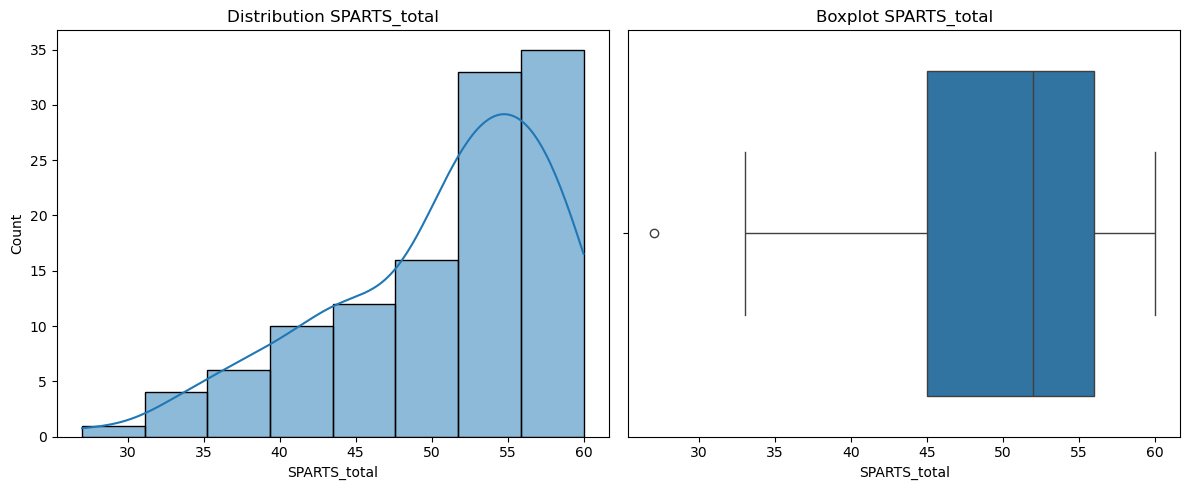

In [446]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Histogram with KDE
sns.histplot(
    data=master,
    x='SPARTS_total',
    kde=True,
    ax=axes[0]  # Plot on the first subplot
)
axes[0].set_title('Distribution SPARTS_total')

# Boxplot
sns.boxplot(
    data=master,
    x='SPARTS_total',
    ax=axes[1]  # Plot on the second subplot
)
axes[1].set_title('Boxplot SPARTS_total')

plt.tight_layout()
plt.show()


Further inspection of SPARTS scores confirms match with total scores: higher frequency of positive closeness scores ~~ higher frequency of negative closeness scores. 

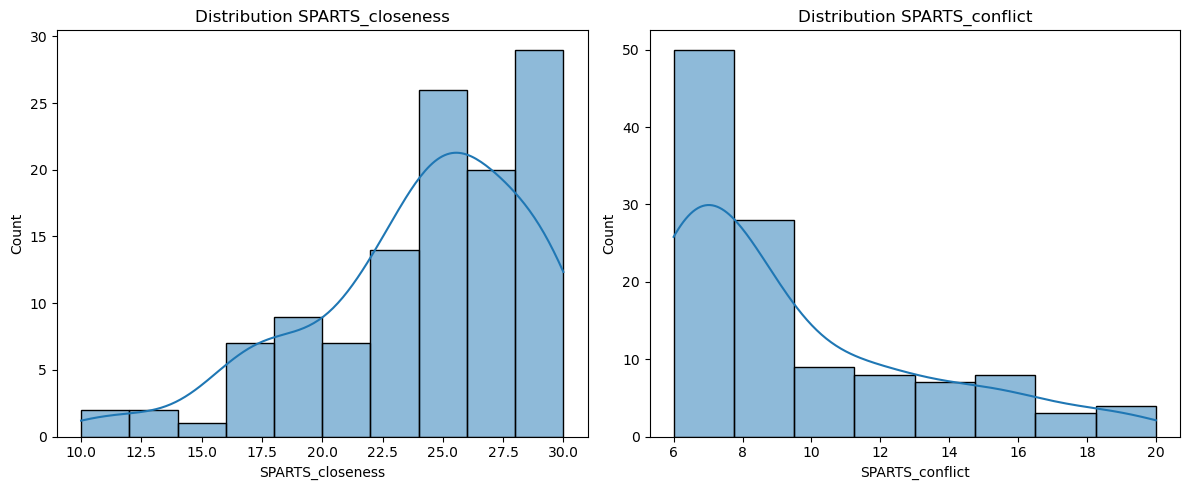

In [447]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

sns.histplot(
    data=master,
    x='SPARTS_closeness',
    kde=True,
    ax=axes[0]  # Plot on subplot 1
)
axes[0].set_title('Distribution SPARTS_closeness')

sns.histplot(
    data=master,
    x='SPARTS_conflict',
    kde = True,
    ax=axes[1]  # Plot on subplot 2
)
axes[1].set_title('Distribution SPARTS_conflict')

plt.tight_layout()
plt.show()

### Normalized scores

Just a first attempt at normalizing the scores here to use in comparison with other scores. Sample st dev used instead of population, as I'm assuming we're generalizing these results (do correct me if I'm wrong). 

In [448]:
from scipy.stats import zscore

sparts['SPARTS_total_z'] = zscore(sparts['SPARTS_total'], ddof=1)  # Sample population st dev; generalization
# outliers = sparts[np.abs(sparts['SPARTS_total_z']) > 3]
# print(f"Number of outliers (|z| > 3): {len(outliers)}")
sparts['SPARTS_total_z'].describe()

count    1.170000e+02
mean     3.121909e-16
std      1.000000e+00
min     -3.216008e+00
25%     -7.700301e-01
50%      1.811836e-01
75%      7.247342e-01
max      1.268285e+00
Name: SPARTS_total_z, dtype: float64

# Exports



In [449]:
filename = 'dataset_partial'
today = pd.to_datetime('today').strftime('%Y-%m-%d_%H-%M')
savepath = DATA_DIR / '02_interim' / f"{filename}_{today}.xlsx"
master.to_excel(savepath, index=False, engine='openpyxl')

## OLD: Export merged file

**08-05-2025:** Below is the code used by Maja to export the first version of the keyfile. Not used anymore, but will keep it here commented.

File includes connection school & class -> subject_id -> tagnumber -> tracklab_id + iop

In [434]:
# ### Temporarily rename school 1 to school 44 to match data
# temp = tracking_data.copy().astype(str)
# temp.loc[temp['school']=='1', 'school'] = '44'
# 
# # temp[temp['school']=='44']
# #todo find out why school 44 has been (inconsistently) renamed school 1, and how we should call it
# 
# # Find the missing tracklab_ids for each school-class combination
# missing_entries = []
# 
# # Get unique school-class combinations from keyfiles
# school_class_combinations = keyfiles[['school', 'class']].drop_duplicates()
# 
# # For each school-class combination
# for _, row in school_class_combinations.iterrows():
#     school = row['school']
#     class_val = row['class']
#     
#     # Get all tracklab_ids for this school-class in tracking_data
#     tracking_ids = temp[(temp['school'] == school) & 
#                         (temp['class'] == class_val)]['tracklab_id'].unique()
#     
#     # Get all tracklab_ids for this school-class already in keyfiles
#     keyfiles_ids = keyfiles[(keyfiles['school'] == school) & 
#                            (keyfiles['class'] == class_val)]['tracklab_id'].unique()
#     
#     # Find tracklab_ids in tracking_data but not in keyfiles
#     missing_ids = set(tracking_ids) - set(keyfiles_ids)
#     
#     # Create new rows for each missing tracklab_id
#     for missing_id in missing_ids:
#         # Create a new row with school, class, and tracklab_id
#         new_row = {
#             'school': school,
#             'class': class_val,
#             'tracklab_id': missing_id
#         }
#         missing_entries.append(new_row)
# 
# # Create df from the missing entries
# if missing_entries:
#     missing_df = pd.DataFrame(missing_entries)
#     
#     # Append missing entries to keyfiles
#     keyfiles = pd.concat([keyfiles, missing_df], ignore_index=True)
#     
#     print(f"Added {len(missing_entries)} new rows to keyfiles for missing tracklab_ids")
# else:
#     print("No missing tracklab_ids found.")
#     
# ### EXPORT TO EXCEL
# export = keyfiles.loc[keyfiles['school'].isin(temp['school'].unique())]
# 
# filename = 'merged-data-WIP'
# today = pd.to_datetime('today').strftime('%Y-%m-%d_%H-%M')
# savepath = DATA_DIR / '02_interim' / f"{filename}_{today}.xlsx"
# # export.to_excel(savepath, index=False, engine='openpyxl')
# 
# # Display df
# keyfiles.sort_values(by=['school', 'class', 'tracklab_id'])[['school', 'class', 'tracklab_id']]

Added 34 new rows to keyfiles for missing tracklab_ids


,school,class,tracklab_id
22,41,100,0x24025F449A89
21,41,100,0x24025F44AD21
28,41,100,0x24025F44DBFA
33,41,100,0x24025F44E6FB
35,41,100,0x24025F44ECCF
...,...,...,...
242,47,108,Tag 1
239,47,108,Tag 2
241,47,108,Tag 3
206,47,108,NaN


In [435]:
# sorting_columns = ['subject_id', 'ID_survey', 'tagnumber']
# keyfiles.loc[keyfiles['tagnumber']=='-', 'tagnumber'] = 1111
# keyfiles.loc[~keyfiles['tagnumber'].astype(str).str.isdigit(), 'tagnumber'] = 1111
# # keyfiles.loc[~keyfiles['consent'].astype(str).str.isdigit(), 'consent'] = 5
# keyfiles[sorting_columns] = keyfiles[sorting_columns].fillna(1111).astype(int, errors='raise') 
# keyfiles.sort_values(by=['school', 'class', 'subject_id','consent','tagnumber'])